In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

plt.style.use('science')


In [2]:
signal = Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)
qcd = Tree(fc.eightb.preselection.QCD_B_List)

In [3]:
treeiter = ObjIter([signal, qcd])

In [9]:
import awkward0 as ak0

# mlp_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/mlp_dijet/output"
gnn_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/graph_jet/graph_jet/output"
# gnn_kin_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/graph_dijet_kin/output"

def load_model_output(path):
    output = ak0.load(path)
    scores = ak.from_awkward0(output['scores'][:,:,1])
    min_score, max_score = ak.min(scores, axis=-1), ak.max(scores, axis=-1)
    return (scores - min_score)/(max_score - min_score)

def load_regex_output(regex):
    print(glob.glob(regex))
    path = glob.glob(regex)[0]
    return load_model_output(path)

In [10]:
import glob 

def load_signal_output(tree):
    mass = tree.sample
    gnn_score = load_regex_output(f"{gnn_path}/*{mass}*")
    tree.extend(jet_gnn_score=gnn_score)
load_signal_output(signal)


['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/graph_jet/graph_jet/output/NMSSM_XYY_YToHH_8b_MX_1000_MY_450_accstudies.awkd']


In [6]:
def load_bkg_output(tree):
    mlp_scores, gnn_scores, gnn_kin_scores = [], [], []
    for f in tree.filelist:
        mlp_scores.append( load_regex_output(f'{mlp_path}/{f.sample}*') )
        gnn_scores.append( load_regex_output(f'{gnn_path}/{f.sample}*') )
        gnn_kin_scores.append(load_regex_output(f"{gnn_kin_path}/{f.sample}*"))
    mlp_scores = ak.concatenate(mlp_scores)
    gnn_scores = ak.concatenate(gnn_scores)
    gnn_kin_scores = ak.concatenate(gnn_kin_scores)
    tree.extend(dijet_mlp_score=mlp_scores, dijet_gnn_score=gnn_scores, dijet_gnn_kin_score=gnn_kin_scores)
load_bkg_output(qcd)

In [7]:
varinfo.dijet_score = dict(bins=np.linspace(0,1,30), xlabel='DiJet Score')
varinfo.dijet_dr    = dict(bins=np.linspace(0,6,30), xlabel='DiJet Jet dR')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


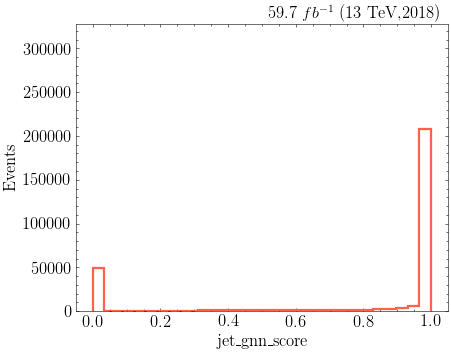

In [11]:
study.quick(
  [signal],
  varlist=['jet_gnn_score']
)

In [12]:
select_jets = CollectionFilter('jet','gnn_jet', filter=lambda t: ak.argsort(ak.argsort(t.jet_gnn_score, axis=-1, ascending=False)) < 8)

signal = select_jets(signal)

In [18]:
signal.extend(gnn_found=ak.sum(signal.gnn_jet_signalId>-1,axis=-1))

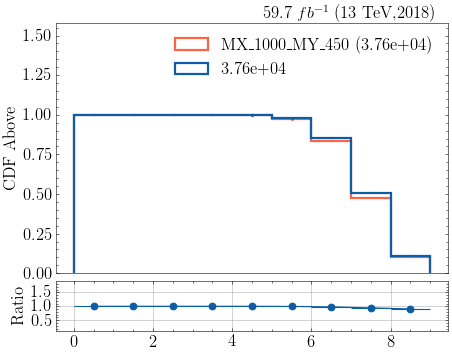

In [23]:
study.overlay(
  [signal], legend=True,
  varlist=['nfound_select','gnn_found'],
  cumulative=-1,

  ratio=True,
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


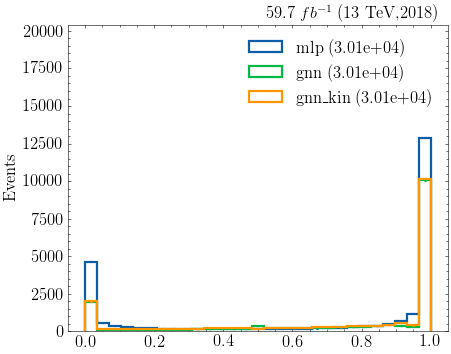

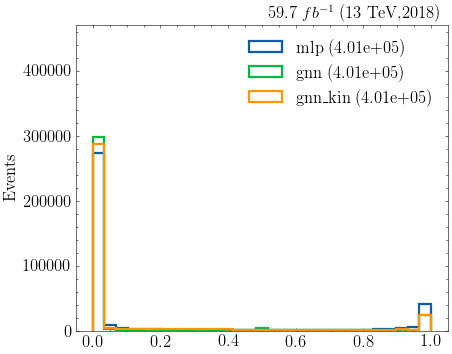

In [8]:
study.overlay(
    [signal],h_color=None,
    masks=lambda t:t.dijet_signalId>-1,
    varlist=['dijet_mlp_score','dijet_gnn_score','dijet_gnn_kin_score'],
    label=['mlp','gnn','gnn_kin'],
    legend=True,
    # density=True,

)

study.overlay(
    [signal],h_color=None,
    masks=lambda t:t.dijet_signalId==-1,
    varlist=['dijet_mlp_score','dijet_gnn_score','dijet_gnn_kin_score'],
    label=['mlp','gnn','gnn_kin'],
    legend=True,
    # density=True,
)

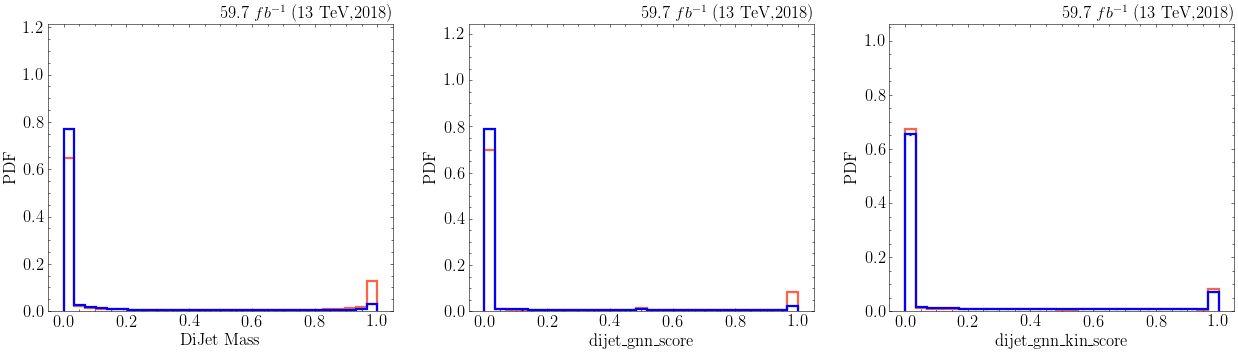

In [9]:
study.quick(
    treeiter,
    varlist=['dijet_mlp_score','dijet_gnn_score','dijet_gnn_kin_score'],
    binlist=[np.linspace(0,1,30)]*2,
    density=True,
    dim=(-1,3),
)

In [10]:
treeiter.apply(lambda tree : select_higgs(tree, nhiggs=4, field='mlp_score', tag='mlp'))
treeiter.apply(lambda tree : select_higgs(tree, nhiggs=4, field='gnn_score', tag='gnn'))
treeiter.apply(lambda tree : select_higgs(tree, nhiggs=4, field='gnn_kin_score', tag='gnn_kin'))


[None, None]

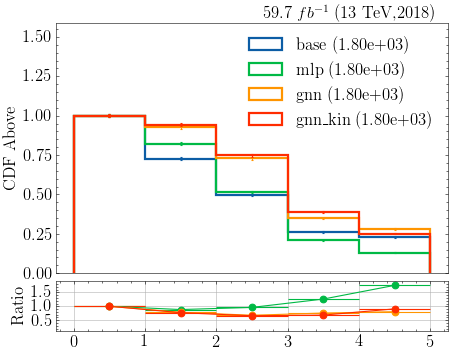

In [11]:
class count_higgs(ObjTransform):
    def __call__(self, tree):
        self.name = f'N {self.var}'
        return ak.sum(tree[f'{self.var}_signalId']>-1,axis=-1)

study.overlay(
    [signal],h_color=None,
    masks=lambda t:t.nfound_presel==8,
    varlist=['nfound_paired_h', count_higgs(var='mlp_higgs'), count_higgs(var='gnn_higgs'), count_higgs(var='gnn_kin_higgs')],
    label=['base','mlp','gnn','gnn_kin'], legend=True,
    binlist=[np.arange(6)]*2, 

    cumulative=-1,
    ratio=True, r_ylim=(0.1,1.9)
)

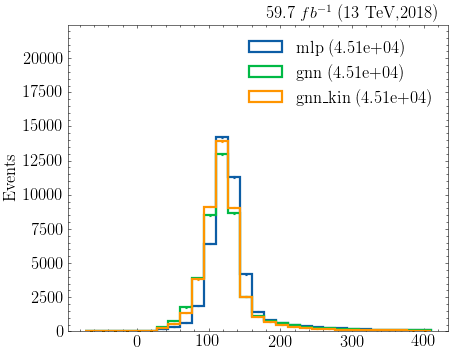

In [12]:
study.overlay(
    [signal],h_color=None,
    varlist=['mlp_higgs_m','gnn_higgs_m','gnn_kin_higgs_m'],
    label=['mlp','gnn','gnn_kin'],legend=True
)

In [13]:
del varinfo['higgs_m']

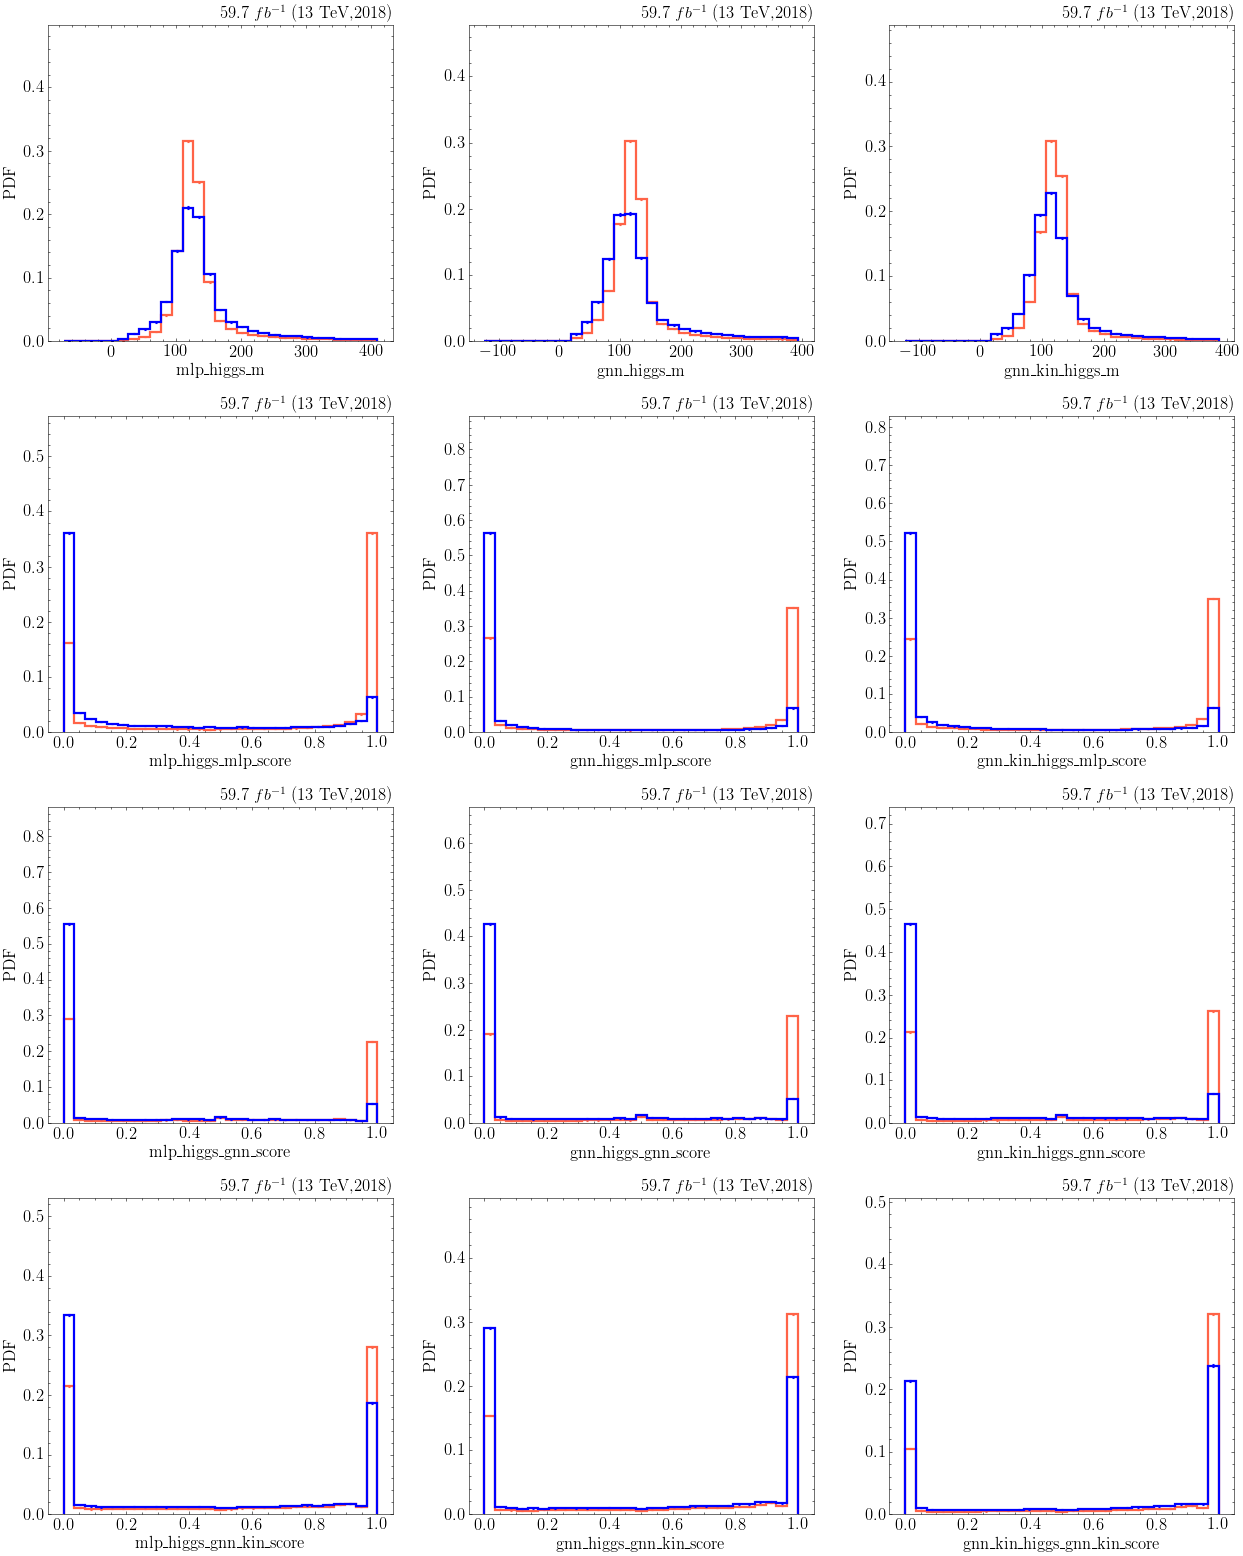

In [14]:
study.quick(
    treeiter,
    varlist=['mlp_higgs_m','gnn_higgs_m','gnn_kin_higgs_m',
            'mlp_higgs_mlp_score','gnn_higgs_mlp_score','gnn_kin_higgs_mlp_score',
            'mlp_higgs_gnn_score','gnn_higgs_gnn_score','gnn_kin_higgs_gnn_score',
            'mlp_higgs_gnn_kin_score','gnn_higgs_gnn_kin_score','gnn_kin_higgs_gnn_kin_score'],
    density=True,
    dim=(-1,3),
)

In [15]:
def calc_higgs_asym(tree, tag='gnn'):
    higgs_m = tree[f"{tag}_higgs_m"]
    hm_asym = eightb.calc_4h_asym(higgs_m)
    tree.extend(**{f"{tag}_{field}":array for field,array in hm_asym.items()})
treeiter.apply(lambda tree : calc_higgs_asym(tree, 'mlp'))
treeiter.apply(lambda tree : calc_higgs_asym(tree, 'gnn'))
treeiter.apply(lambda tree : calc_higgs_asym(tree, 'gnn_kin'))


[None, None]

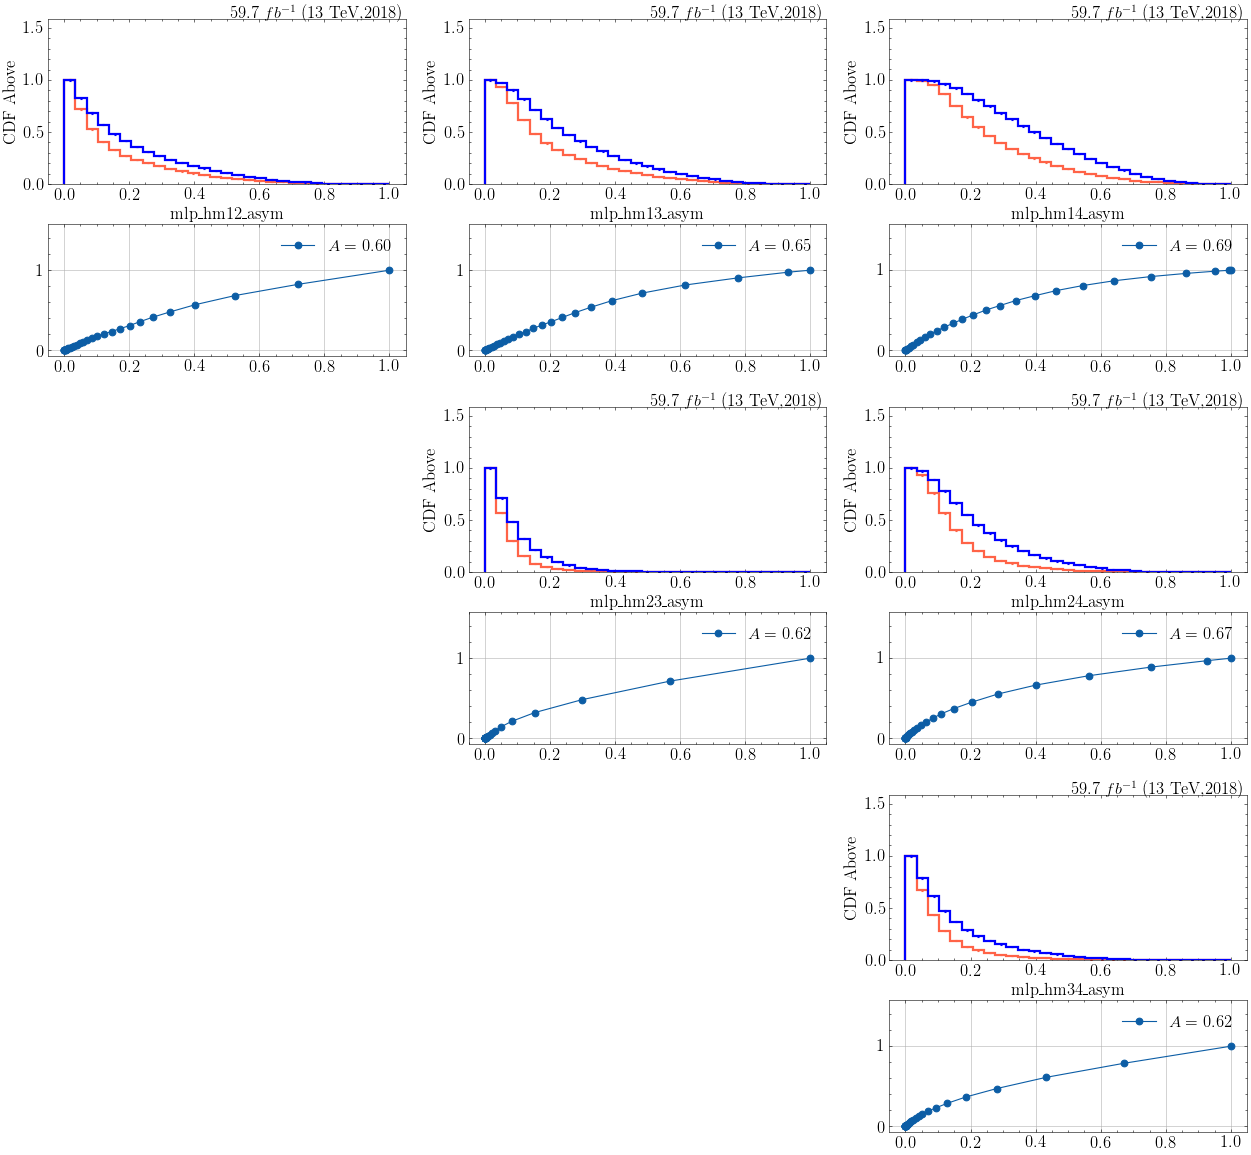

In [16]:
varlist=["hm12_asym","hm13_asym","hm14_asym",None,"hm23_asym","hm24_asym",None,None,"hm34_asym"]


study.quick(
    treeiter,
    varlist=[f"mlp_{asym}" if asym is not None else None for asym in varlist],
    dim=(-1, 3),binlist=[np.linspace(0,1,30)]*9,

    cumulative=-1,
    correlation=True, c_size="80%"
)

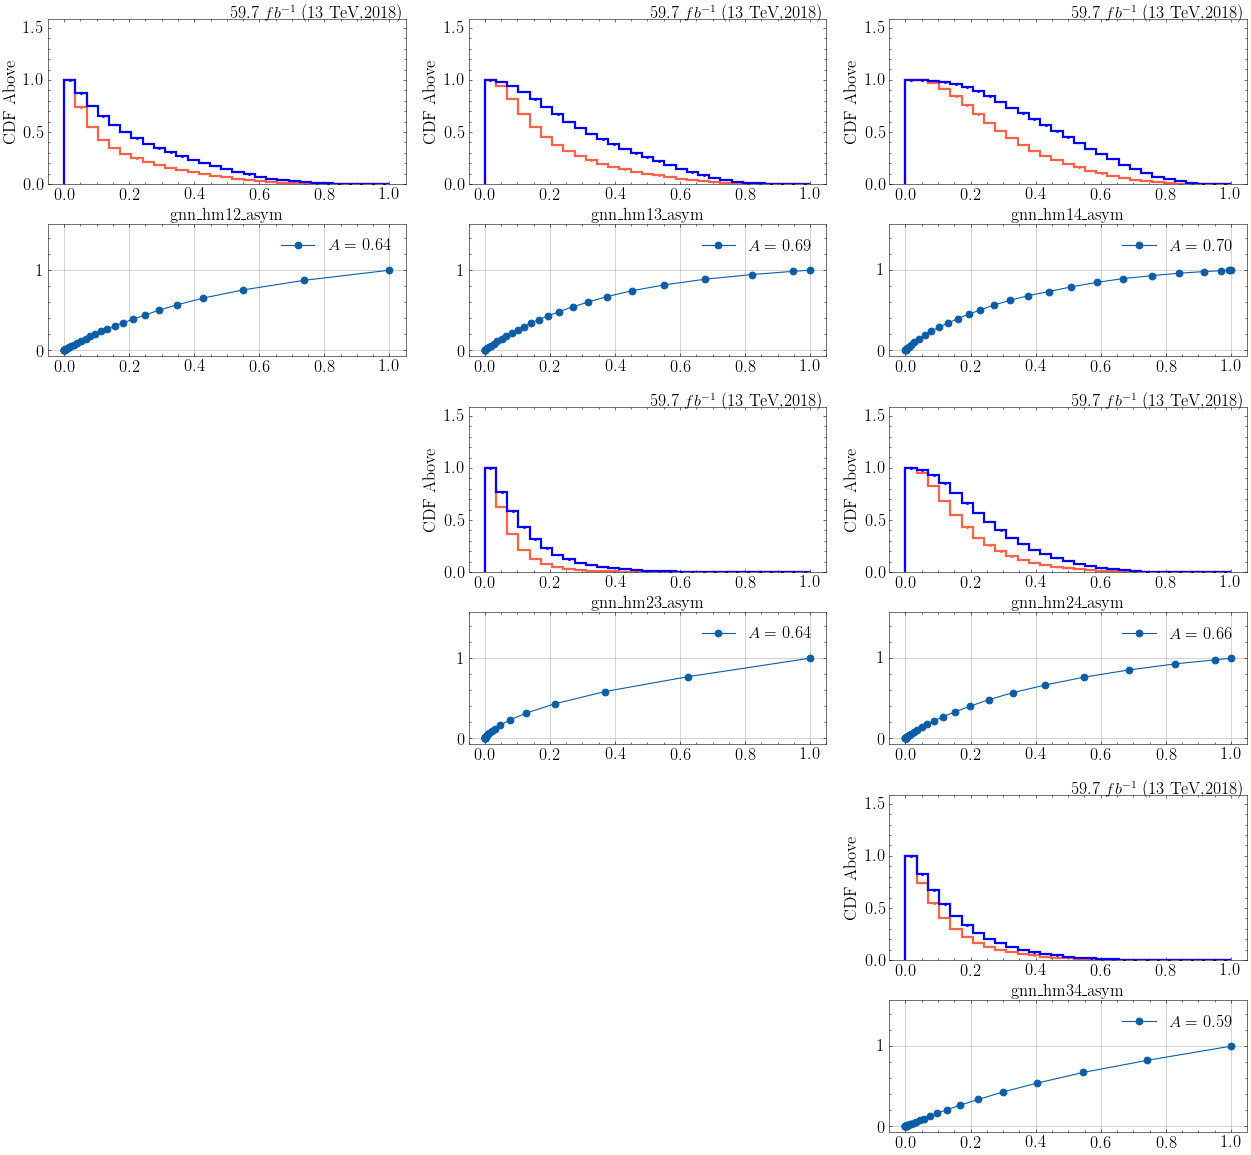

In [17]:
study.quick(
    treeiter,
    varlist=[f"gnn_{asym}" if asym is not None else None for asym in varlist],
    dim=(-1, 3),binlist=[np.linspace(0,1,30)]*9,

    cumulative=-1,
    correlation=True, c_size="80%"
)

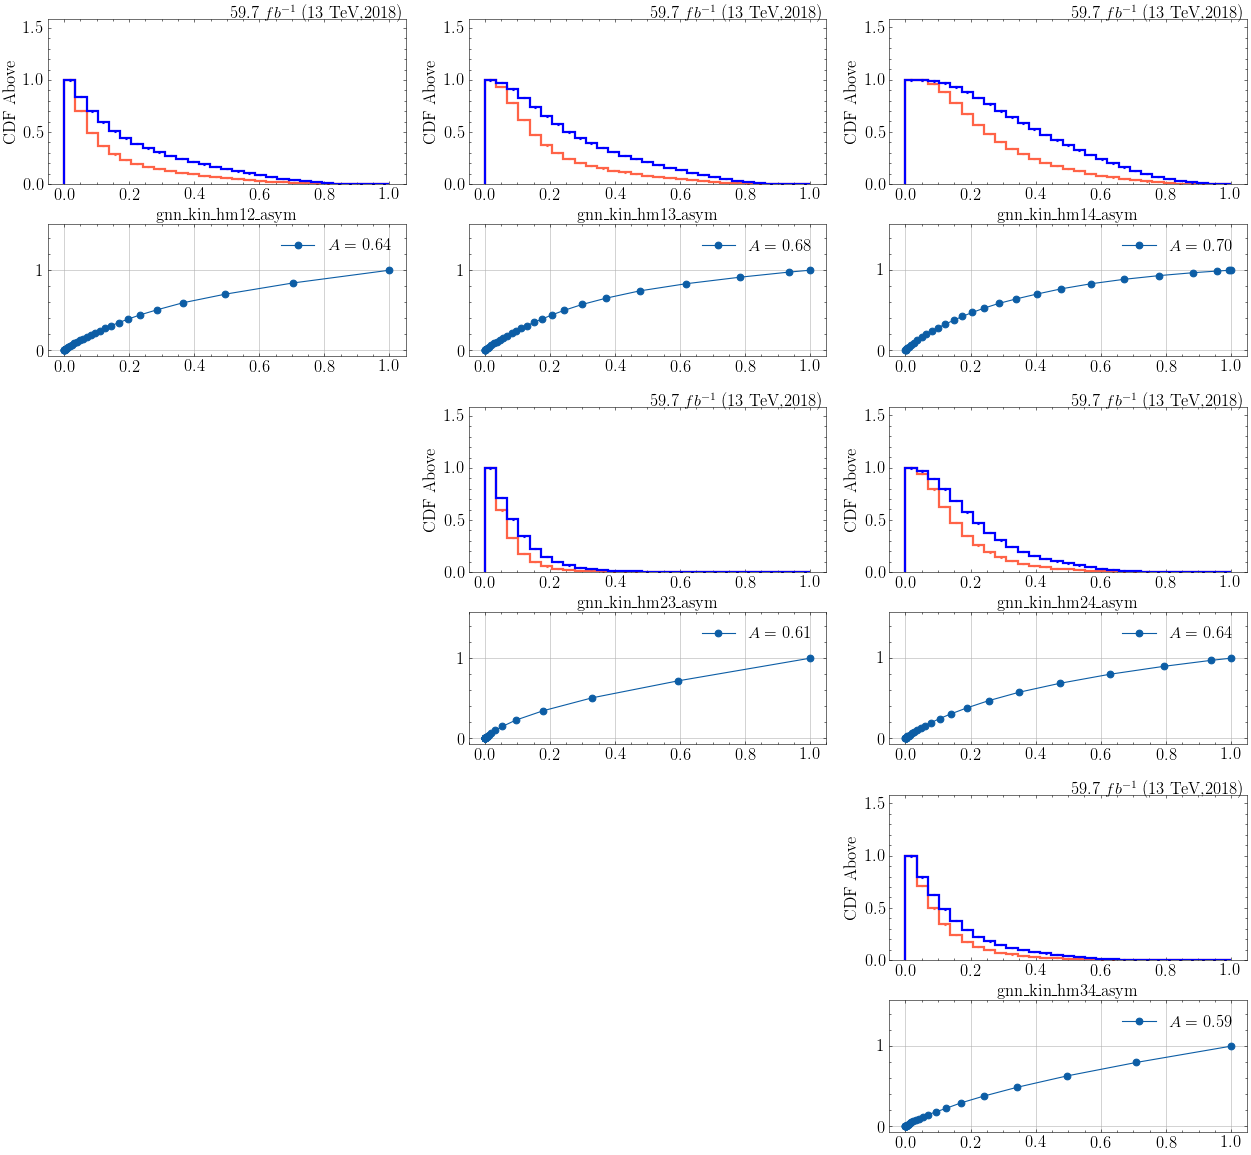

In [18]:
study.quick(
    treeiter,
    varlist=[f"gnn_kin_{asym}" if asym is not None else None for asym in varlist],
    dim=(-1, 3),binlist=[np.linspace(0,1,30)]*9,

    cumulative=-1,
    correlation=True, c_size="80%"
)